In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)

def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s
    Compute finbert sentiment on the text.
    - max_lenght=512 for stability
    - SoftMax to ensure equal weights'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def count_positive(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('positive', 0)

def count_negative(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('negative', 0)

def count_neutral(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('neutral', 0)

def calc_conviction(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus/agreement.
    Lower value = High disagreement or mostly neutral news.
    Slightly modified to take into account neutral article -> conviction Index
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    conviction = 1 - np.sqrt(1 - inner_val)
    
    return conviction

def compute_volatility(df):
    """Compute volatility following Antweiller and Frank Methodology
    - residual of MA1
    - log Squared residuals
    - added variation with soxx(index for tech industries)"""
    # MA 1
    model = ARIMA(df['log_return'], order=(0, 0, 1))
    model_fit = model.fit()    

    df['ln_vi_t'] = np.log(model_fit.resid**2)

    df['ln_vi_t_soxx'] = np.log((df['log_return']-df['soxx_ret'])**2)
    
    return df

def add_ts(metrics):

    """Features Engineering, adding indicators and dummy variables
    get everything in Panel Format for regression, as well shift position
    (lag variables)"""

    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]

    stocks_data = yf.Tickers(stocks)
    hist = stocks_data.history(period='4y', interval="1d")
    
    data_subset = hist[['Close', 'Volume', 'Dividends']]
    prices_long = data_subset.stack(level=1).reset_index()
    prices_long.columns = ['date', 'label', 'price', 'volume', 'dividend']

    prices_long['dividend_dummy'] = np.where(prices_long['dividend'] > 0, 1, 0)
    
    prices_long = prices_long.sort_values(['label', 'date'])

    prices_long['log_return'] = prices_long.groupby('label')['price'].transform(
        lambda x: 100*np.log(x/x.shift(1))
    )
    
    prices_long['log_return_lag'] = prices_long.groupby('label')['log_return'].shift(1)
    prices_long['lag_neg'] = np.where(prices_long['log_return_lag']<0,1,0)

    prices_long['log_volume'] = np.log(prices_long['volume'])
    prices_long['log_volume_lag'] = prices_long.groupby('label')['log_volume'].shift(1)

    prices_long['date'] = prices_long['date'].dt.strftime('%Y-%m-%d')

    soxx = yf.Ticker("SOXX").history(period='5y')[['Close']]
    soxx['soxx_ret'] = 100*np.log(soxx['Close']/soxx['Close'].shift(1))
    soxx.index = pd.to_datetime(soxx.index.date).strftime('%Y-%m-%d')
    soxx = soxx[['soxx_ret']].reset_index().rename(columns={'index': 'date'})

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')
    combined_df = combined_df.merge(soxx, on='date', how='left')

    combined_df['bullishness_lag'] = combined_df.groupby('label')['bullishness_index'].shift(1)
    combined_df['conviction_lag'] = combined_df.groupby('label')['conviction_index'].shift(1)
    combined_df['article_count_lag'] = combined_df.groupby('label')['article_count'].shift(1)
    combined_df['n_positive_lag'] = combined_df.groupby('label')['n_positive'].shift(1)
    combined_df['n_neutral_lag'] = combined_df.groupby('label')['n_neutral'].shift(1)
    combined_df['n_negative_lag'] = combined_df.groupby('label')['n_negative'].shift(1)
    combined_df['soxx_ret_lag'] = combined_df.groupby('label')['soxx_ret'].shift(1)

    combined_df = combined_df.dropna()

    combined_df.sort_values('date',ascending=True,inplace=True)

    combined_df = combined_df.groupby('label', group_keys=False).apply(compute_volatility)

    return combined_df

Device set to use cuda:0


# ARTICLES
We scrape the article as explain in the paper. We took the codes a youtube video (https://www.youtube.com/watch?v=5tpEDlUCzjk). Initially the codes where limited to headers. We extended his work to also enter into the url and clened the articles. Moreover we speeded up the scraping x10 by using parallelization. For sake of brevity we will just print the codes below. It takes more than one hour to run.

In [25]:
import requests

url = "https://raw.githubusercontent.com/LeonSavi/T-M-Project/refs/heads/master/multi_threading_scraper.py"

print(requests.get(url).text)

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from newspaper import Article
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# Configuration
STOCKS = ["AMD", "ASML", "GOOG", "META", "NVDA"]
PAGES_PER_STOCK = 500
MAX_WORKERS = 20  # Number of concurrent threads
ROOT_URL = 'https://markets.businessinsider.com'

# Thread-safe storage
results_lock = threading.Lock()
pandas_dct = defaultdict(list)

def get_article_content(url):
    """Downloads and parses a single article."""
    try:
        article = Article(url)
        article.download()
        article.parse()
        txt = article.text
        paragraphs = [p.strip() for p in txt.split('\n') if p.strip()]
        first_paragraph = paragraphs[0] if paragraphs else ""
        return txt, first_paragraph
    except Exception:
        return None, None

def process_article_metadata(stock, art_soup):
    """Extracts metadata from 

# DATA
Data are scraped as mentioned above and run. Below you load the row data and assign the sentiment with FinBERT. Description of how finbert_sentiment works is in the paper and youtube video (https://www.youtube.com/watch?v=4KoYlMii8hM).

In [ ]:
# GET DATA PARQUET FROM GITHUB REPO
url = "https://github.com/LeonSavi/T-M-Project/raw/refs/heads/master/scraped_data.parquet"

data = pd.read_parquet(url,engine='auto')

SENTIMENT_REF_COLUMN = 'fist_parag'

data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data[SENTIMENT_REF_COLUMN].apply(finbert_sentiment).apply(pd.Series)

# INDICATORS
Compute indicators, including:calc_bullishness,calc_agreement, count_positive,count_neutral, count_negative, count_article. Filter for finbert sentiments with 0.5 probabilities or above. Moreover add Returns for each stock and more. More details in the functions.

In [27]:
# compute metrics i.e. market bullishness and agreement
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)

# filter for certain articles

TRESHOLD = 0.5
cond = (
    ((data['fb_positive']>TRESHOLD) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>TRESHOLD) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>TRESHOLD) & (data['sentiment']=='negative'))
)

metrics = data[cond].groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    conviction_index = calc_conviction,
    article_count = 'count',
    n_positive = count_positive,
    n_neutral = count_neutral,
    n_negative = count_negative

)

clean_data = add_ts(metrics)

clear_output()

# REGRESSION 1
Regression as in the paper of Antweiler and Frank 2004 for volatility analysis.

In [28]:
# volatility as in the paper
X_returns = clean_data[['conviction_lag',
                        'article_count_lag',
                        'lag_neg',
                        'log_volume_lag'
                        ]]
X_returns = sm.add_constant(X_returns)
y_returns = clean_data['ln_vi_t']

model_returns = sm.OLS(y_returns, X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     11.70
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           2.12e-09
Time:                        17:35:40   Log-Likelihood:                -4968.1
No. Observations:                2196   AIC:                             9946.
Df Residuals:                    2191   BIC:                             9975.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.6815      0.64

# ANOMALIES/HIGH VOLATILITY EVENTS
Get High Vol event as described in the paper. We run our add-hoc class to identify them. More detail in the class.

In [29]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

anomalies = stock_anomaly.get_anomalies()
anomalies['date'] = anomalies['date'].dt.strftime('%Y-%m-%d')
anomalies['high_volatility'] = int(1)

merged_data = clean_data.merge(anomalies[['date','stock','high_volatility']],
                              how='left',
                              left_on = ['date', 'label'],
                              right_on = ['date','stock'])

merged_data.drop(columns='stock',inplace=True)
merged_data['high_volatility'] = merged_data['high_volatility'].fillna(0)
merged_data['high_vol_tmrrw'] = merged_data['high_volatility'].shift(-1)

[*********************100%***********************]  5 of 5 completed


# WEIGHTING
Compute Weights for Logistic Regression. As there are few anomalous days we give more weights to those.

In [30]:
# weighting
n_total = len(merged_data)
n_events = merged_data['high_volatility'].sum()
n_normal = n_total - n_events

# Weight for the rare event (Class 1) and normal day (Class 0)
weight_event = n_total / (2 * n_events)
weight_normal = n_total / (2 * n_normal)

weights = merged_data['high_volatility'].apply(lambda x: weight_event if x == 1 else weight_normal)
n_events,n_normal

(np.float64(53.0), np.float64(2143.0))

# REGRESSION 2
Logistic Regression for probablity of Anomalous day (High Volatility Event).

In [31]:
pred = ['bullishness_lag',
        'conviction_lag',
        'article_count_lag',
        'lag_neg',
        'log_volume_lag']

predictors = sm.add_constant(
    merged_data[pred]
)

weighted_model = sm.GLM(merged_data['high_volatility'], predictors,
                        family=sm.families.Binomial(), freq_weights=weights).fit()

print(weighted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        high_volatility   No. Observations:                 2196
Model:                            GLM   Df Residuals:                  2190.00
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1508.1
Date:                Sun, 01 Feb 2026   Deviance:                       3016.3
Time:                        17:35:40   Pearson chi2:                 2.20e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01268
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0315      0.52

# CHARTS
Additional Charts to support regressions.
1. Mean Volatility by conviction group
2. Probability of an high volatility event by bullishness bucket
3. Anomalous/high volatility days charts

/tmp/ipykernel_96893/4261531017.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conviction_group',


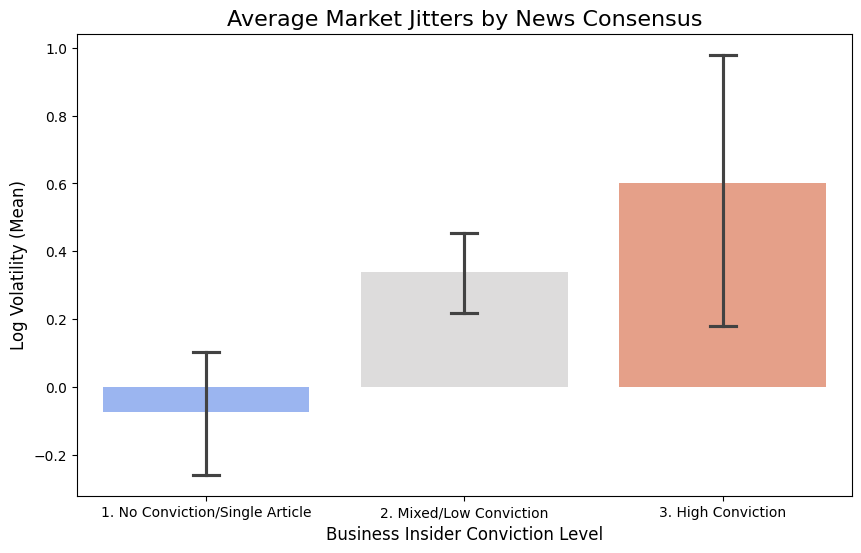

In [ ]:
def categorize_conviction(x):
    if x == 0: return "1. No Conviction/Single Article"
    if x < 0.5: return "2. Mixed/Low Conviction"
    return "3. High Conviction"

clean_data['conviction_group'] = clean_data['conviction_lag'].apply(categorize_conviction)

plt.figure(figsize=(10, 6))
sns.barplot(x='conviction_group',
            y='ln_vi_t',
            data=clean_data,
            palette='coolwarm',
            capsize=.1,
            order=[
    "1. No Conviction/Single Article", 
    "2. Mixed/Low Conviction", 
    "3. High Conviction"
        ])

plt.title('Average Market Jitters by News Consensus', fontsize=16)
plt.xlabel('Business Insider Conviction Level', fontsize=12)
plt.ylabel('Log Volatility (Mean)', fontsize=12)
plt.show()

/tmp/ipykernel_96893/2949357347.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100
/tmp/ipykernel_96893/2949357347.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')


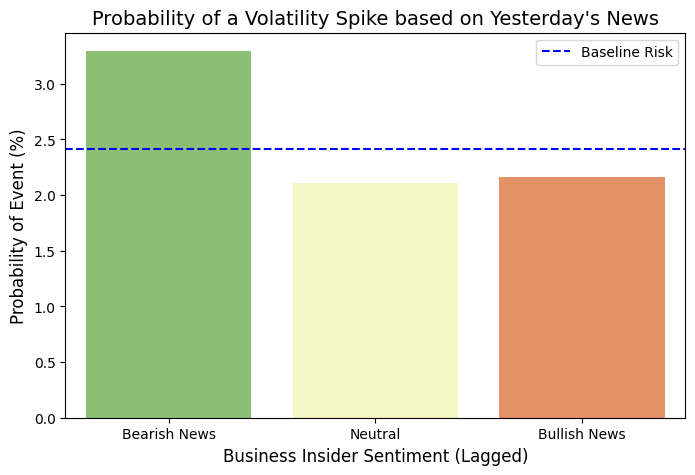

In [ ]:
# Bullishness Buckets
merged_data['sentiment_type'] = pd.cut(merged_data['bullishness_lag'], 
                                       bins=[-np.inf, -0.1, 0.1, np.inf], 
                                       labels=['Bearish News', 'Neutral', 'Bullish News'])

# Calculate the Probability
prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')

plt.title('Probability of a Volatility Spike based on Yesterday\'s News', fontsize=14)
plt.ylabel('Probability of Event (%)', fontsize=12)
plt.xlabel('Business Insider Sentiment (Lagged)', fontsize=12)
plt.axhline(merged_data['high_volatility'].mean()*100, color='blue', linestyle='--', label='Baseline Risk')
plt.legend()
plt.show()

[*********************100%***********************]  5 of 5 completed


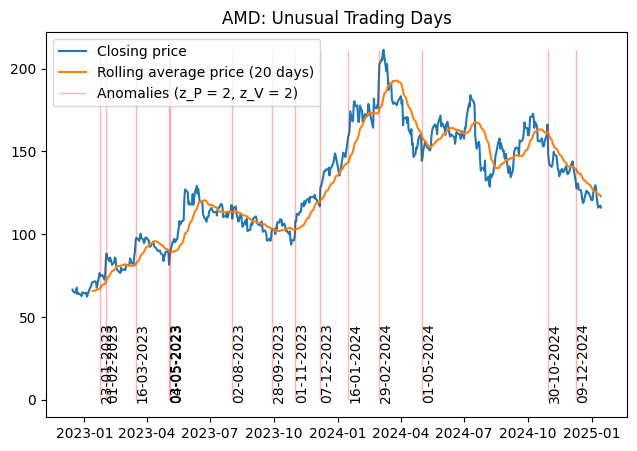

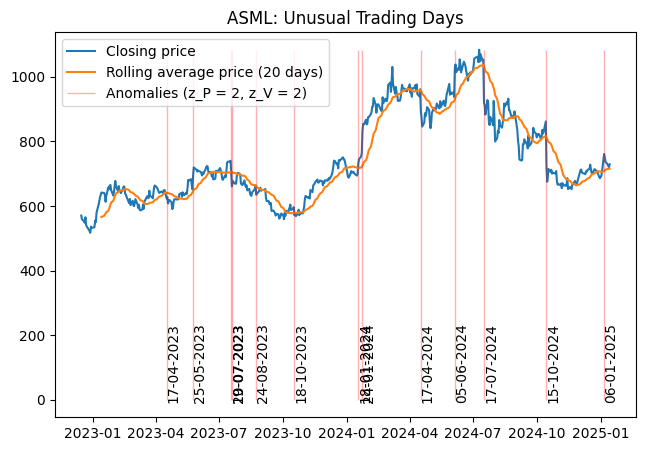

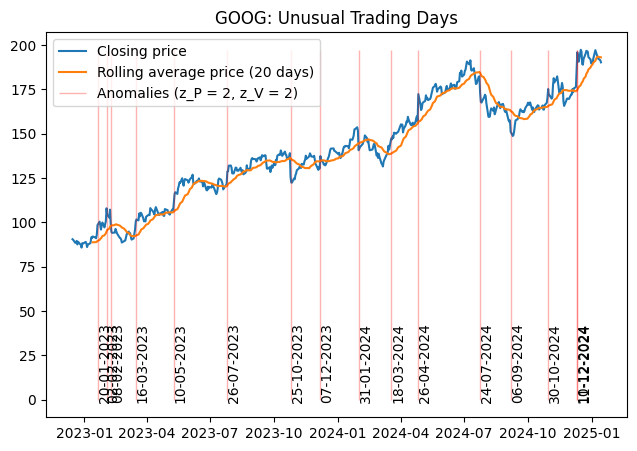

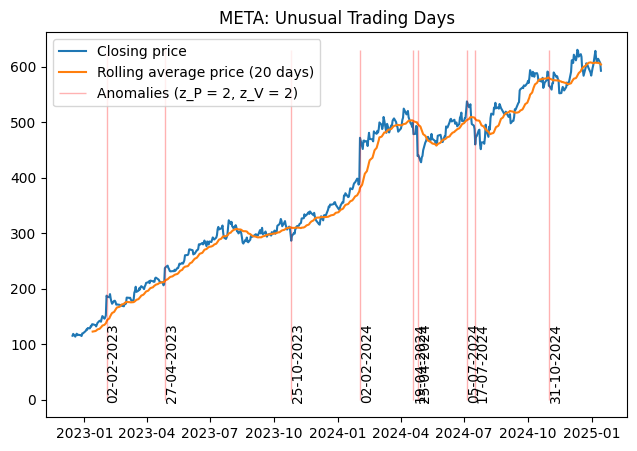

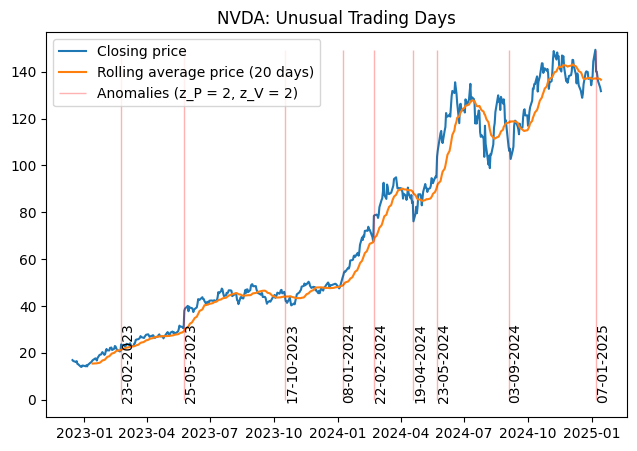

In [34]:
anomalies = StockAnomaly(start='2022-12-15',end='2025-01-15')
anomalies.calculate(window=20,price_z=2,volume_z=2)

for i in anomalies.stocks:
    anomalies.display_anomalies(i,(7.5,5))